In [1]:
from os.path import join as pjoin
from os.path import exists as exist
from os.path import isfile
from os import listdir as lsdir
from os import makedirs
from obspy.taup import TauPyModel
import obspy
import matplotlib.pyplot as plt
import numpy as np
from obspy.signal.cross_correlation import xcorr_max, correlate
import scipy.signal as signal
from obspy.geodetics import gps2dist_azimuth
from obspy.geodetics import kilometer2degrees
from scipy.optimize import minimize
import re

import SS_MTI
import Create_Vmod
from EventInterface import EventObj
import subprocess
from SS_MTI import PostProcessing as _PostProcessing
from SS_MTI import PreProcess as _PreProcess
from SS_MTI import PhaseTracer as _PhaseTracer
from SS_MTI import Gradient as _Gradient

In [2]:
def Get_location(la_s, lo_s, la_r, lo_r, radius=3389.5, flattening=0):
    """
    Get the epicentral distance, azimuth and backazimuth
    """
    dist, az, baz = gps2dist_azimuth(
        lat1=la_s, lon1=lo_s, lat2=la_r, lon2=lo_r, a=radius, f=flattening
    )
    epi = kilometer2degrees(dist, radius=radius)
    return epi, az, baz


In [3]:
def read_refl_mseeds(path: str,dt:float, stack: bool = False):
    """ 
    This functions reads in the output of reflectivity code (miniseeds)
    :param pat:the path where the miniseeds are located
    :param stack: stacks the streams in one array (Z,R,T) -> numpy.array
    :returns: obspy stream for stack = False, numpy.array for stack = True
    """

    st = obspy.Stream()
    st_files = [f for f in lsdir(path) if f.startswith("st") if isfile(pjoin(path, f))]

    for st_file in st_files:
        st_temp = obspy.read(pjoin(path, st_file))

        st_temp[0].stats.channel = "xx" + st_file.split(".")[-1]
        distance = st_temp[0].stats.sac.gcarc
        st_temp[0].stats.distance = distance

        B = st_temp[0].stats.sac.b  # beginning time
        tstart = st_temp[0].stats.starttime  # absolute starttime
        et0 = tstart - B
        st_temp[0] = st_temp[0].trim(
            starttime=tstart - B, endtime=st_temp[0].stats.endtime, pad=True, fill_value=0.0
        )
        st += st_temp

    st.select(channel="xxz")[0].data *= -1
    st.select(channel="xxt")[0].data *= -1
    if stack:
        Z = st.select(channel="xxz")[0].data
        R = st.select(channel="xxr")[0].data
        T = st.select(channel="xxt")[0].data
        return np.hstack((np.hstack((Z, R)), T))
    else:
        return st

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed


/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:292: RuntimeWarning: divide by zero encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))
/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:292: RuntimeWarning: invalid value encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))


Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...
6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...
6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...
6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...
6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...
6.53569

/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/3.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52671178825e-09
model parameter nr 4 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/4.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.53569161678e-09
model parameter nr 5 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/5.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 6 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/6.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52667482529e-09
model parameter nr 7 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/7.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56872671082e-09
model parameter nr 8 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/8.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.5779432008e-09
model parameter nr 0 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/0.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 1 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/1.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.52657607026e-09
model parameter nr 2 is updated now
depth of MOHO (from TAYAK) will be changed
Building obspy.taup model for '/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/2.tvel' ...


/home/nienke/Documents/Research/SS_MTI/SS_MTI/Gradient.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  for i, phase in enumerate(phases):


6.56370426136e-09
model parameter nr 3 is updated now
depth of MOHO (from TAYAK) will be changed


KeyboardInterrupt: 

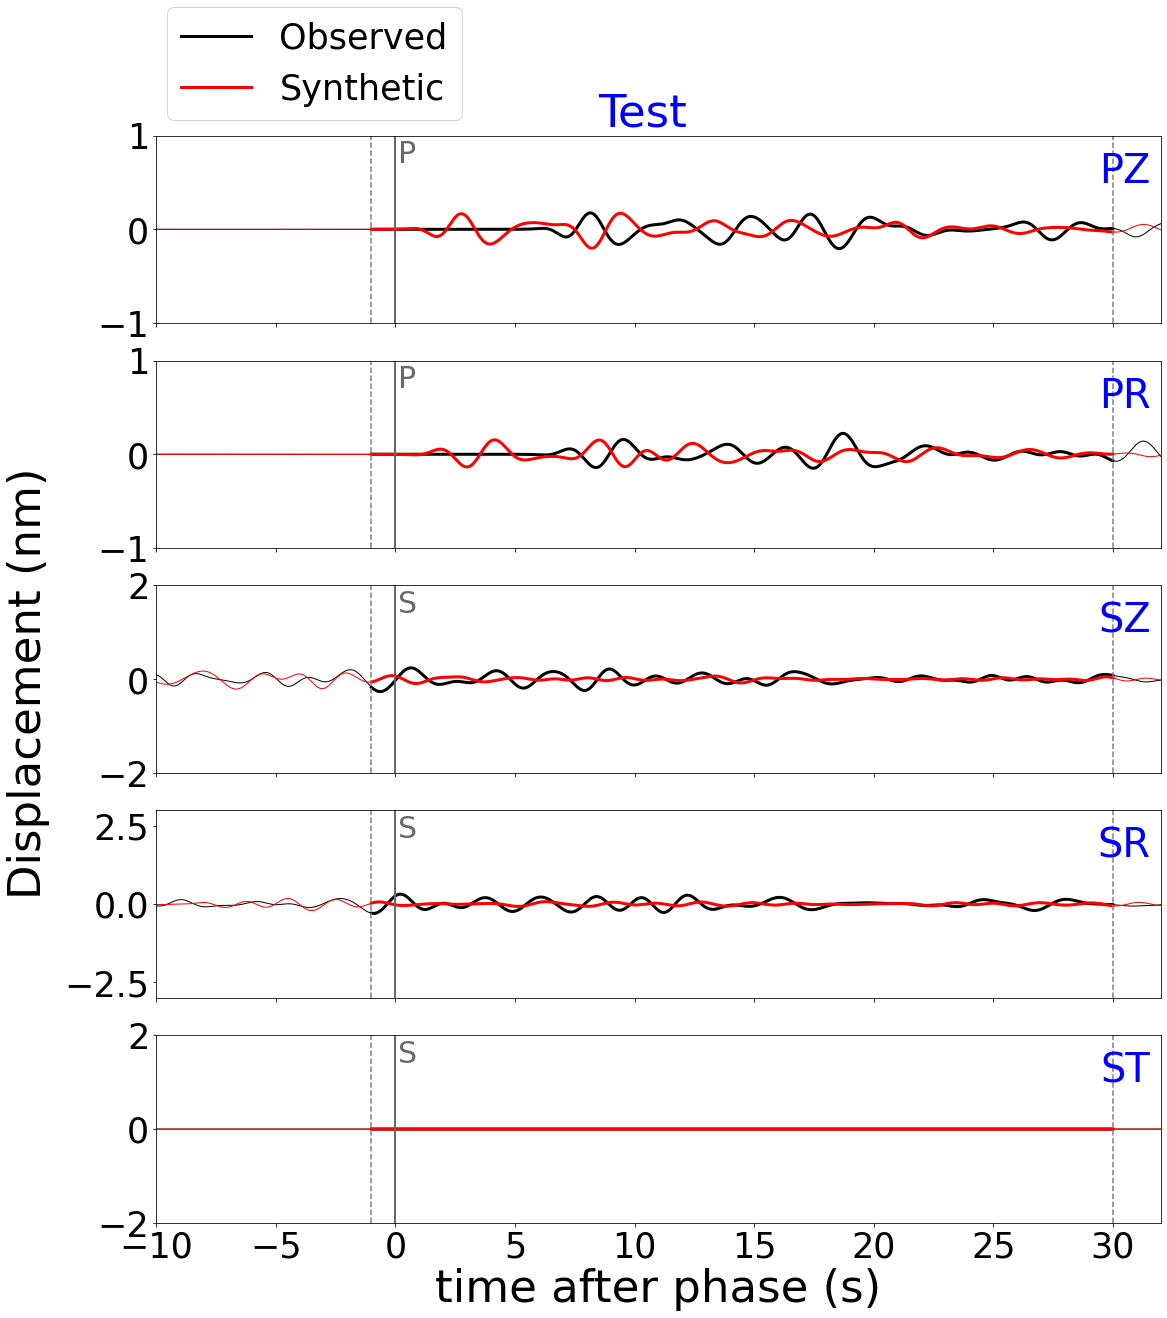

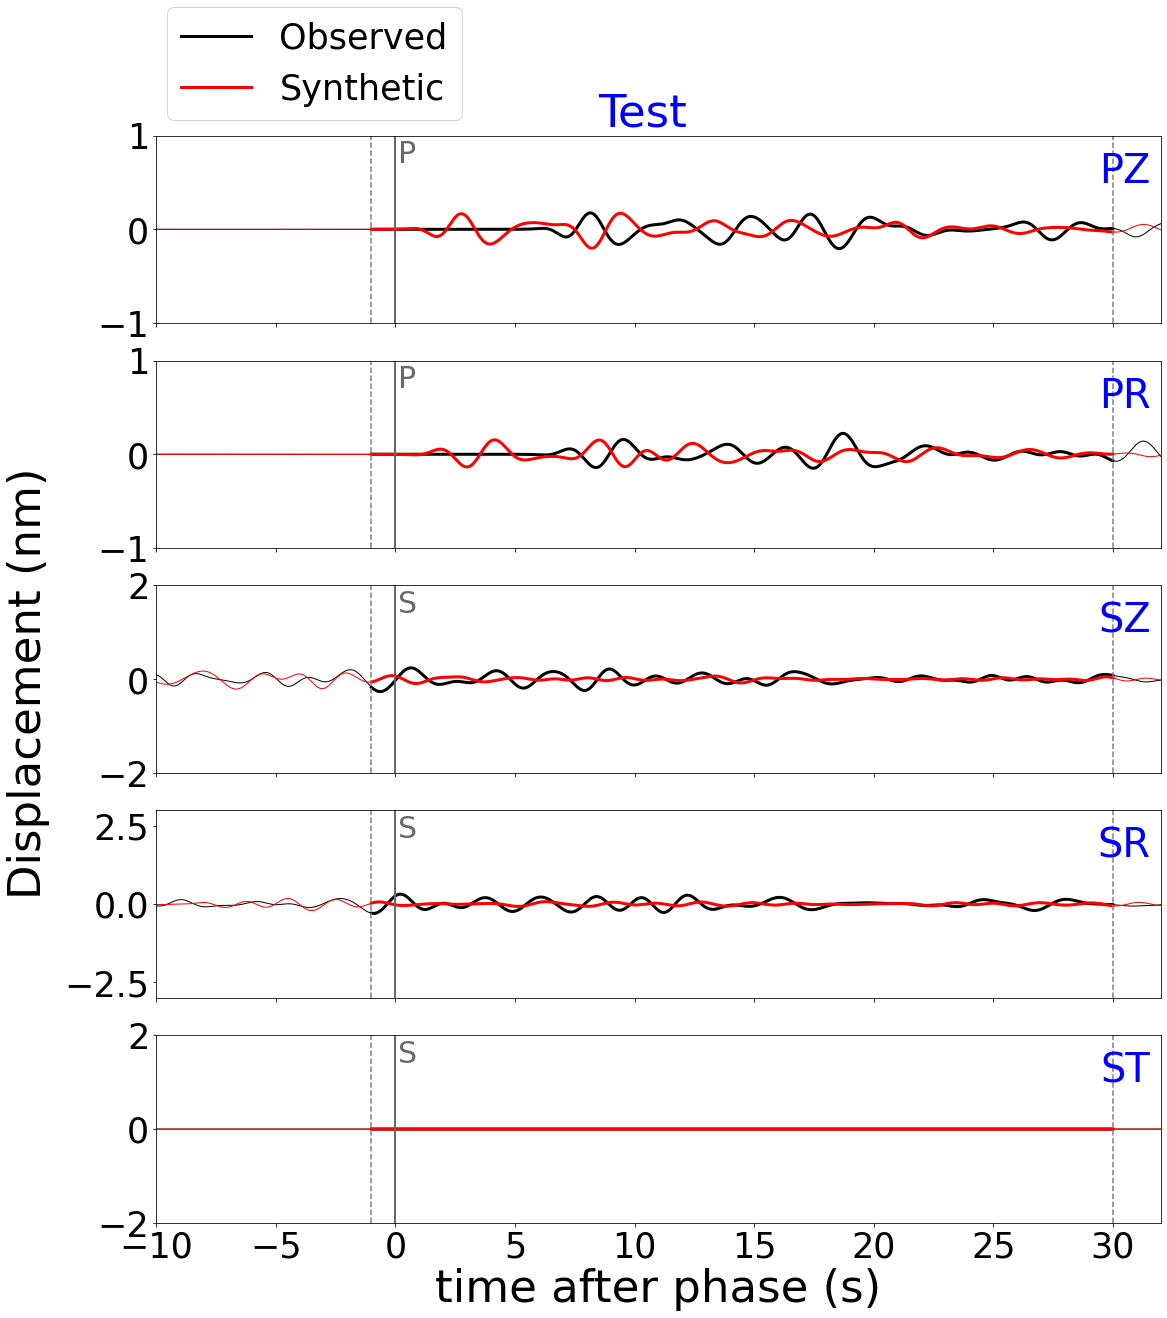

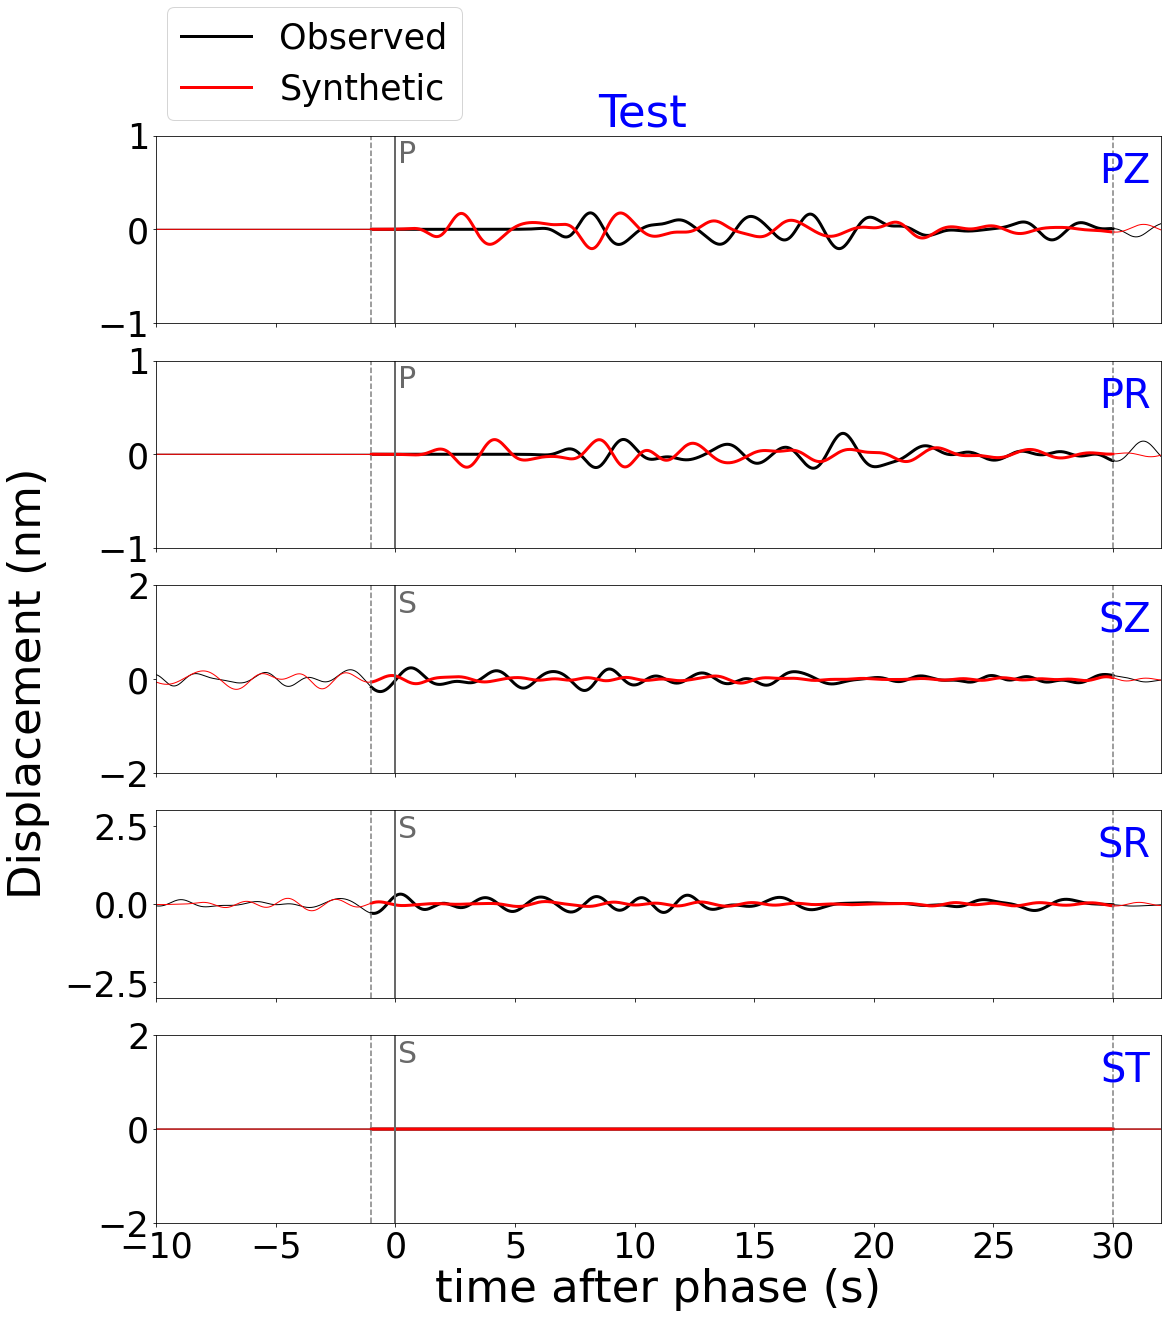

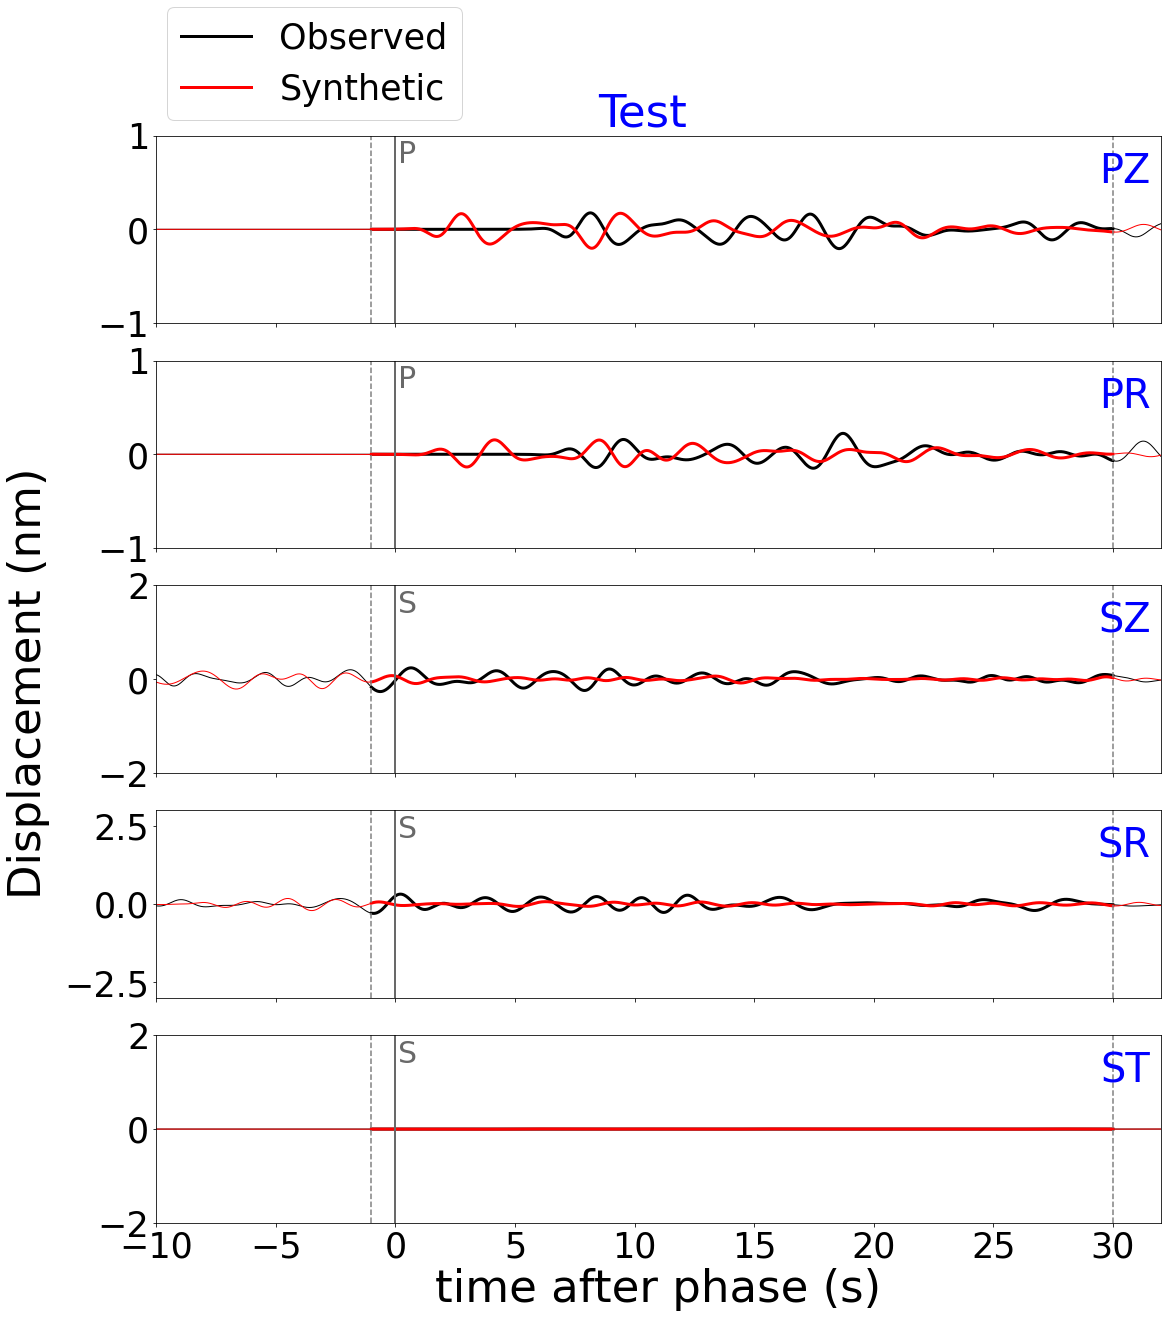

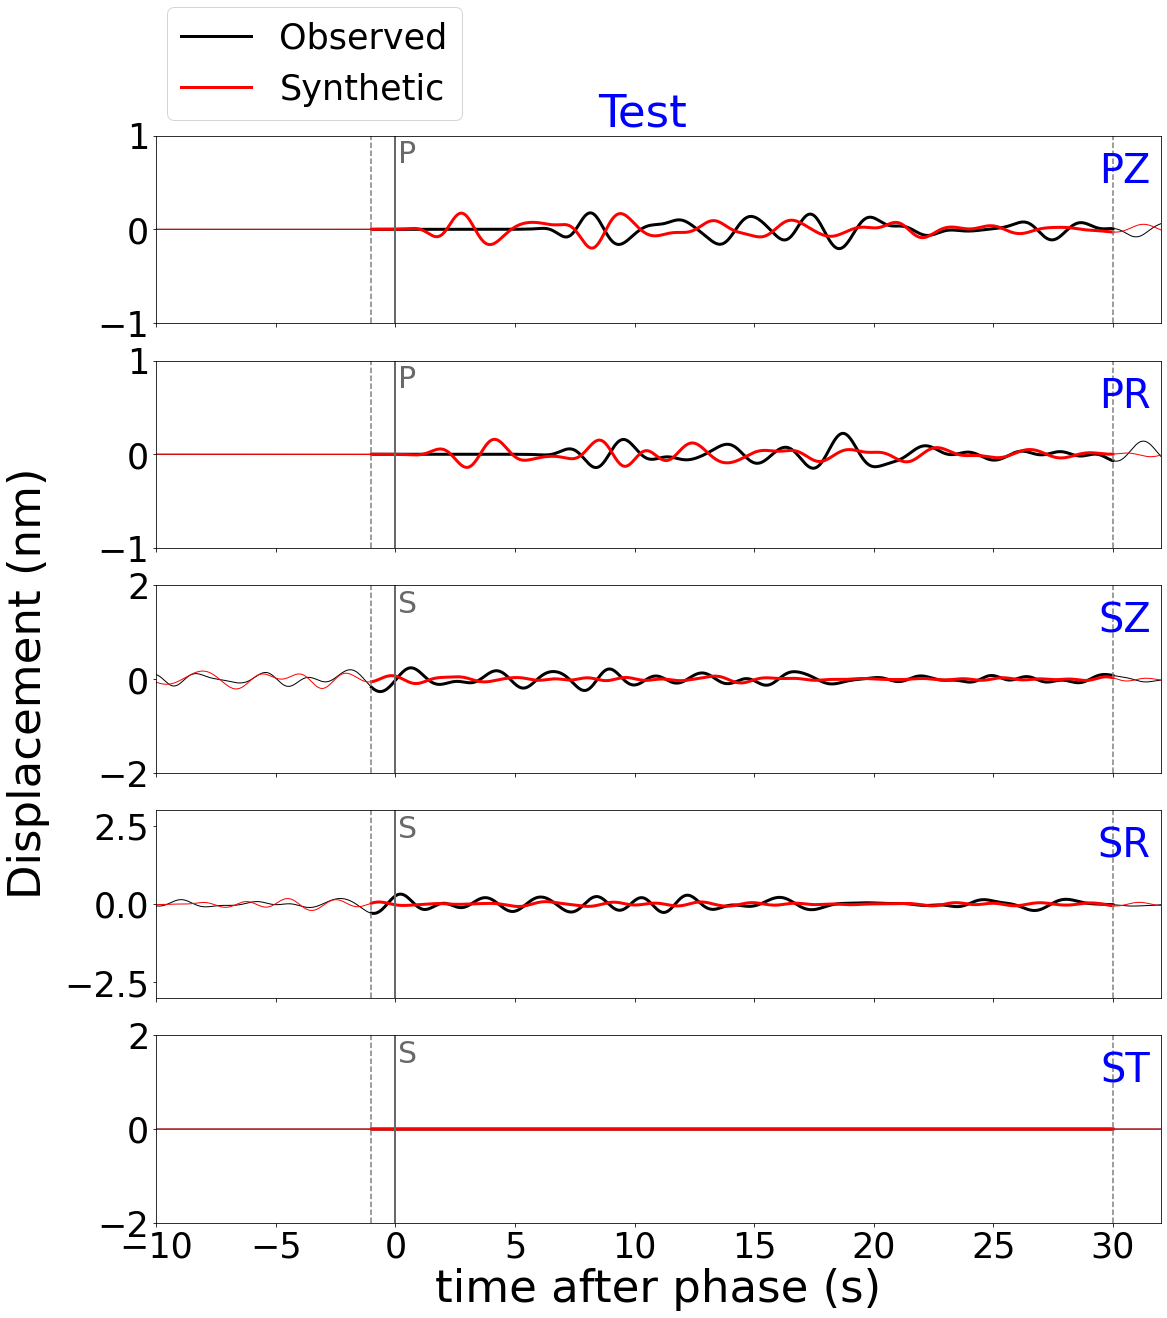

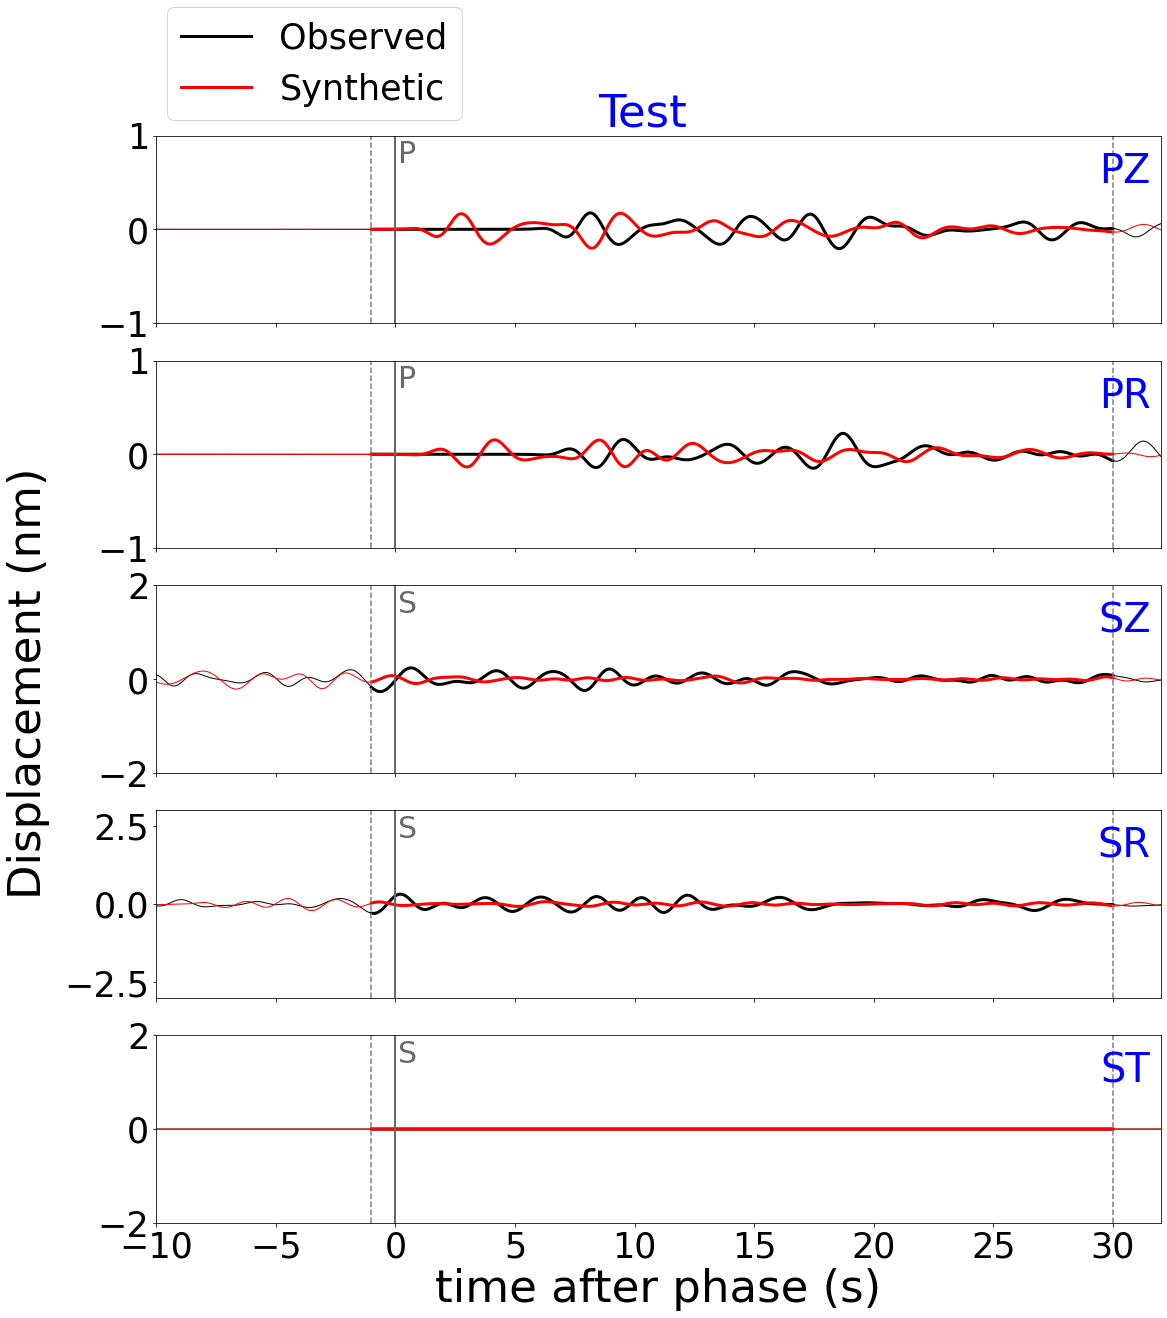

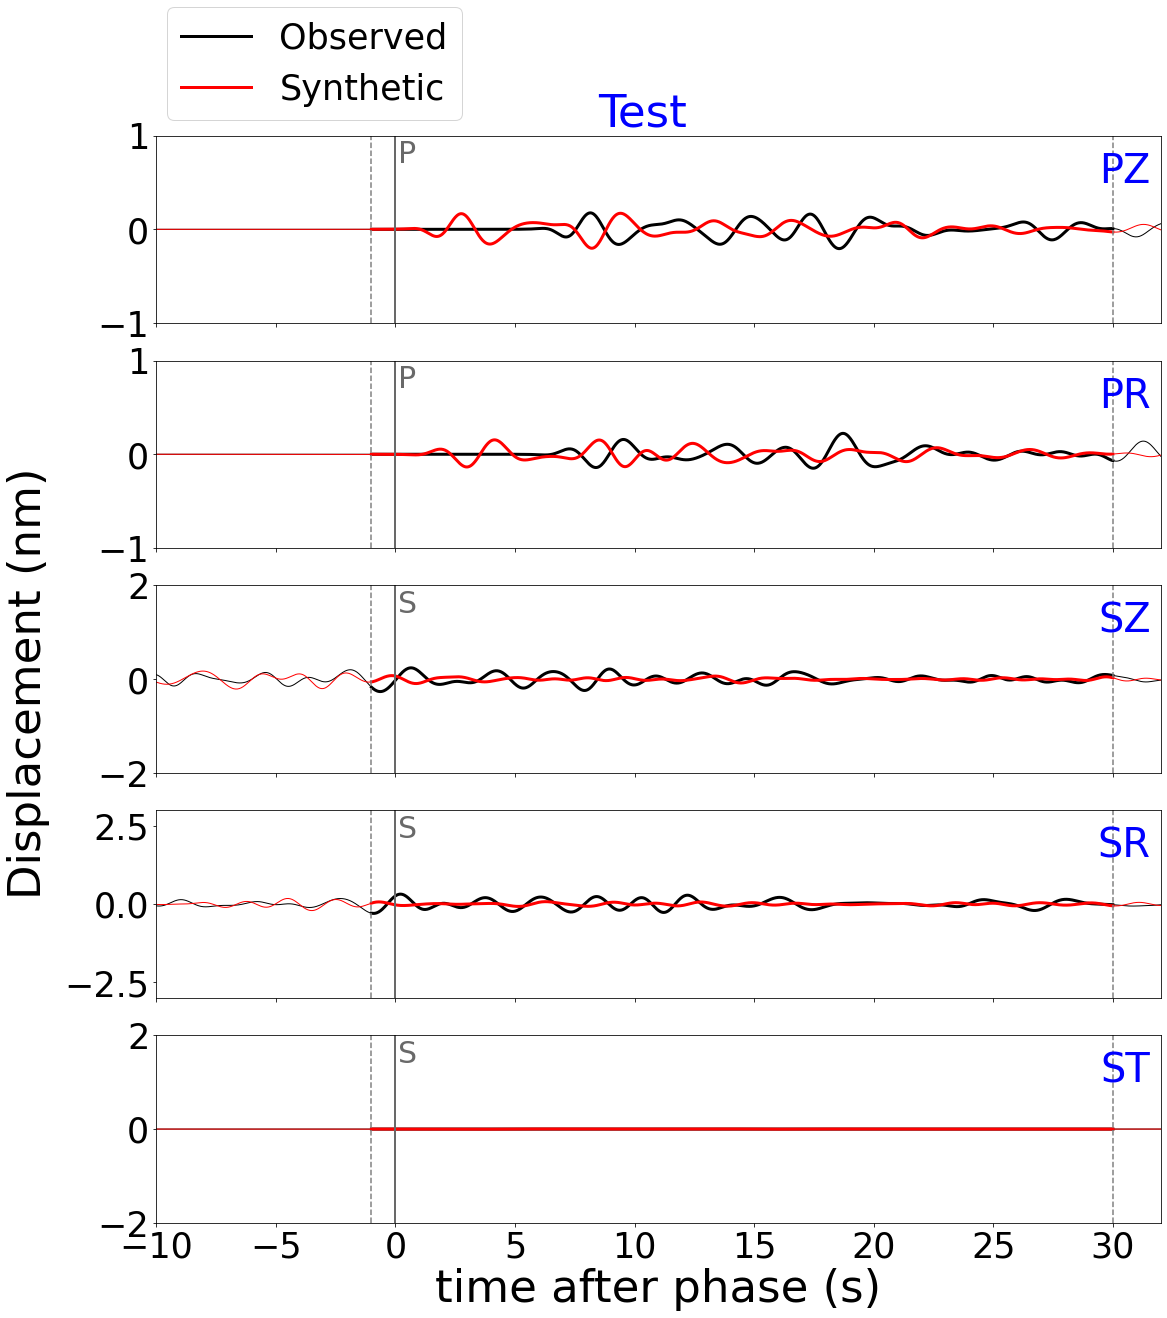

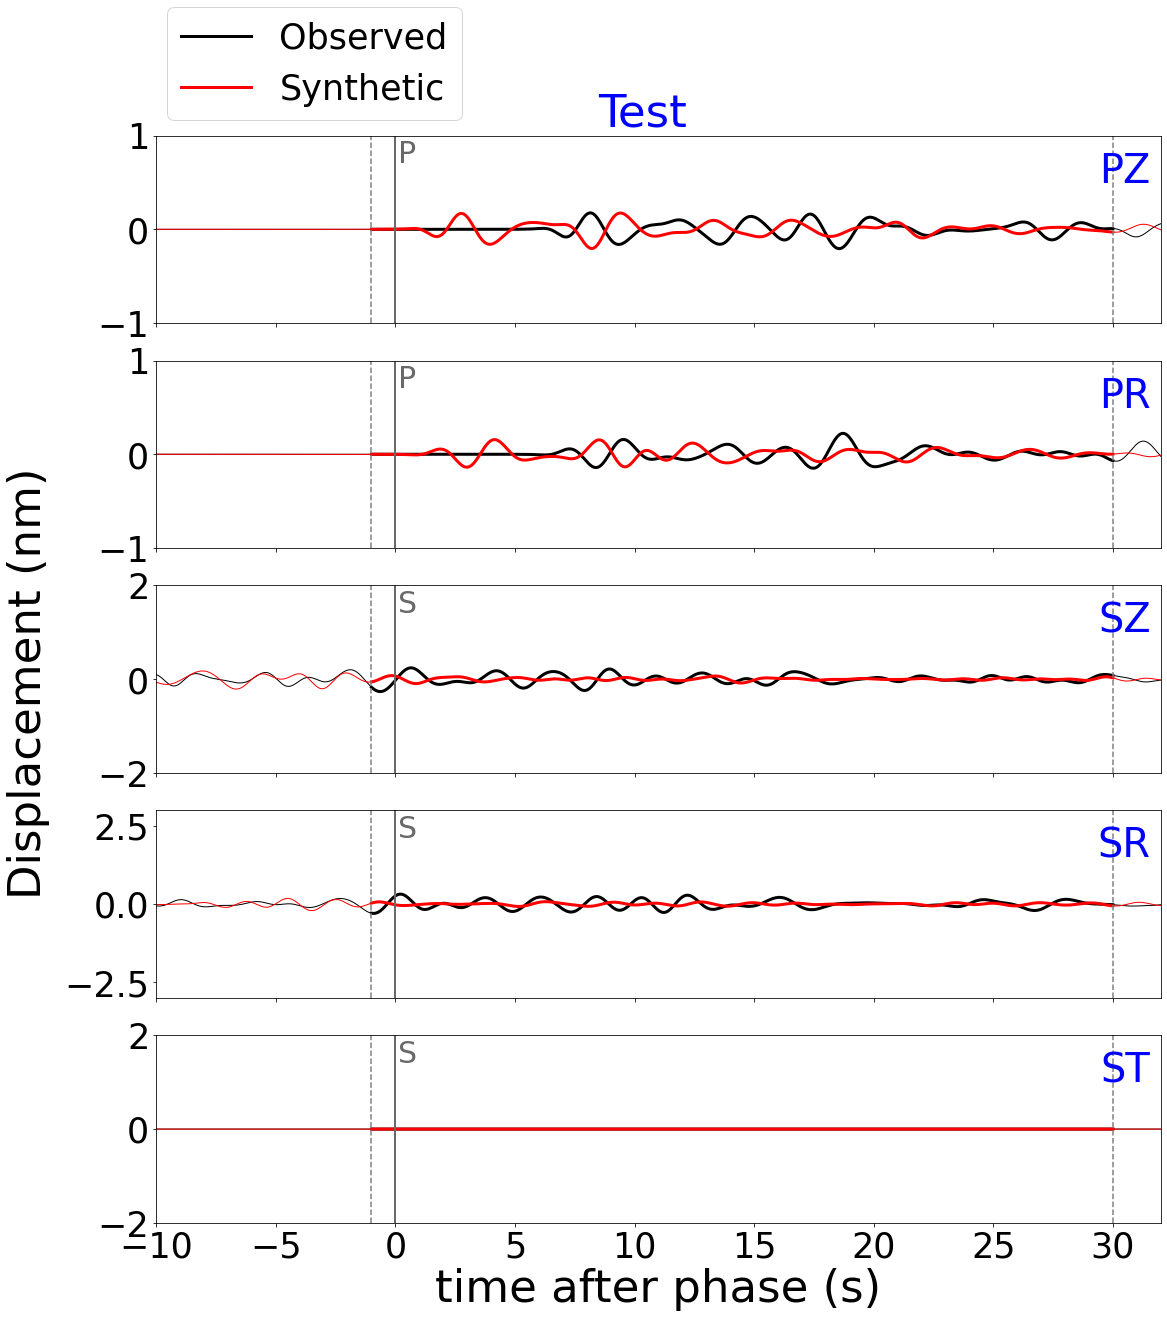

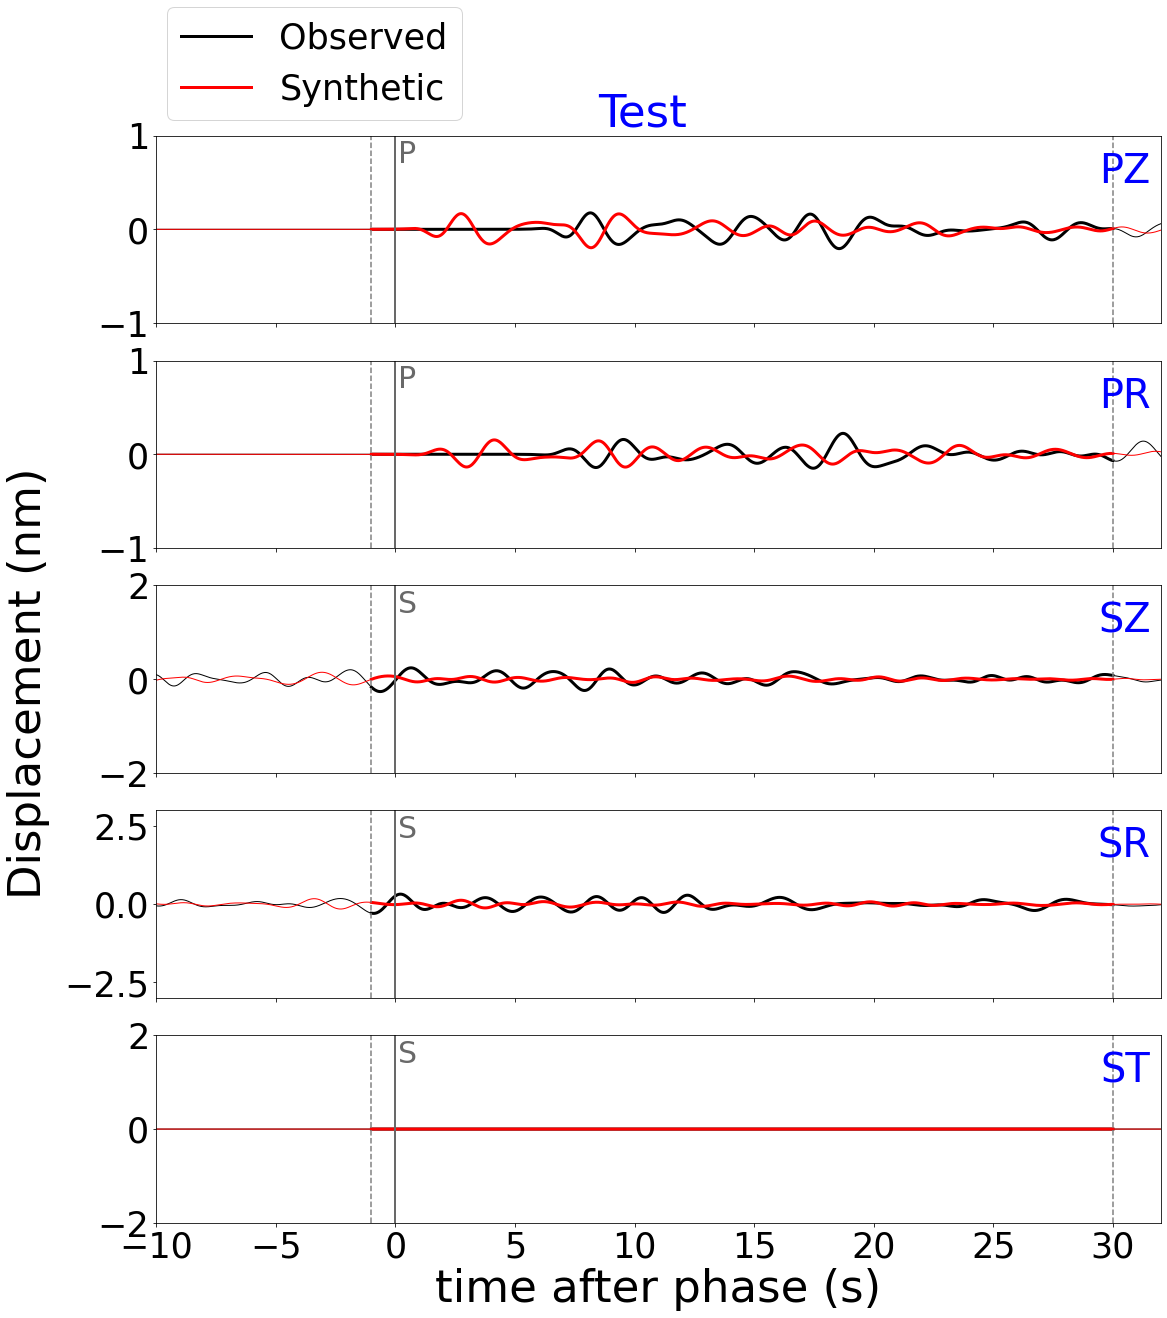

Error in callback <function flush_figures at 0x7f88f9f1bd30> (for post_execute):


KeyboardInterrupt: 

In [8]:

# path of the reclectivity binary:
bin_path = (
    "/home/nienke/Documents/Research/SS_MTI/External_packages/reflectivity_Mars/SRC/test/crfl_sac"
)

""" Define starting parameters """
or_time = obspy.UTCDateTime("2020-3-10T12:00:00")
lat_src = 0
lon_src = 0
depth = 20.0
name = "Test_Event"

npz_file = "/home/nienke/Documents/Research/Data/npz_files/TAYAK.npz"
model = TauPyModel(npz_file)

lat_rec = -30
lon_rec = 0

dt = 0.025

epi, az, baz = Get_location(lat_src, lon_src, lat_rec, lon_rec)

m_rr0 = 0.5
m_tt0 = 0.5
m_pp0 = 0.0
m_rt0 = 0.0
m_rp0 = 0.0
m_tp0 = 0.0
focal_mech0 = [m_rr0, m_tt0, m_pp0, m_rt0, m_rp0, m_tp0]

phases = ["P", "P", "S", "S", "S"]
comps = ["Z", "R", "Z", "R", "T"]
t_pres = [1, 1, 1, 1, 1]
t_posts = [30, 30, 30, 30, 30]
ylims = [1e-9, 1e-9, 2e-9, 3e-9, 2e-9]

fmin = 0.2
fmax = 0.6
zerophase = False

# This is basically your prior model, you need to set this up once:
save_path = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0/"


""" Create observed data array (for the moment all synthetic)"""
path_observed = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/obs/"
st_obs = read_refl_mseeds(path_observed, dt,stack=False)
""" Travel times of observed data """
npz_file = "/home/nienke/Documents/Research/Data/npz_files/TAYAK_BKE.npz"
Taup = TauPyModel(npz_file)
obs_tts = []
for i, phase in enumerate(phases):
    obs_tts.append(_PhaseTracer.get_traveltime(Taup, phase, depth, epi))
""" Window the observed data """
st_obs_w = obspy.Stream()  # keep this one for plotting
st_obs_full = obspy.Stream()
for i, phase in enumerate(phases):
    tr_full = st_obs.select(channel=f"xx{comps[i]}")[0].copy()
    if fmin is not None and fmax is not None:
        _PreProcess.filter_tr(tr_full, fmin=fmin, fmax=fmax, zerophase=zerophase)
    o_time = tr_full.stats.starttime
    tr = tr_full.slice(
        starttime=o_time + obs_tts[i] - t_pres[i], endtime=o_time + obs_tts[i] + t_posts[i],
    )
    st_obs_w += tr
    st_obs_full += tr_full


""" """
# check if folder exists:
if not exist(save_path):
    makedirs(save_path)
# check if folder is empty
if not lsdir(save_path):
    subprocess.call(f"scp {bin_path} .", shell=True, cwd=save_path)
bm_file_path = "/home/nienke/Documents/Research/Data/MTI/MT_vs_STR/bm_models/TAYAK.bm"
Create_Vmod.create_dat_file(
    src_depth=depth,
    focal_mech=focal_mech0,
    M0=None,
    epi=epi,
    baz=baz,
    save_path=save_path,
    bm_file_path=bm_file_path,
)

""" Get the parameter (m) array ready """
import pandas as pd

dat_path = pjoin(save_path, "crfl.dat")
dat_file = pd.read_csv(
    dat_path, skiprows=3, skipfooter=11 + 7, header=None, delim_whitespace=True, engine="python",
)

with open(dat_path, "r+") as f:
    data = f.readlines()
    f.close()
moment_param = np.array(re.findall("\d+\.\d+", data[-8]), dtype=float)
depths = dat_file.values[0:10:2, 0] + 10.0
MOHO = 50.0  # depths[5]
vp = dat_file.values[0:10:2, 1] + dat_file.values[0:10:2, 1] * 0.01
vs = dat_file.values[0:10:2, 3] + dat_file.values[0:10:2, 3] * 0.01

"""
4 different cases that you can try:
1. Changing only the MOHO depth (depth = True, vpvs = False)
2. Changing the depths only (depth = True, vpvs = False) 
3. Changing the vpvs only (depth = False, vpvps = True)
4. Changing the depth and vpvps (depth = True, vpvps = True)
"""
m0 = np.hstack((moment_param, MOHO))  # Case 1
# m0 = np.hstack((moment_param, depths)) # Case 2
# m0 = np.hstack((np.hstack((moment_param, vp)), vs)) # Case 3
# m0 = np.hstack((np.hstack((np.hstack((moment_param, depths)), vp)), vs)) # Case 4

depth = True
vpvs = False

""" 
Start the misfit function with your initial model 
(i.e., it will run the forward model and calculates the misfit)
"""
n_it = 10
fac = 1  # factor that you want to multiply with the gradient
epsilon = 0.1
xis = np.zeros(n_it)
dxi_dms = np.zeros((len(m0), n_it))
m0s = np.zeros((len(m0), n_it + 1))
m0s[:, 0] = m0

src_str = _Gradient.SRC_STR(
    binary_file_path=bin_path,
    path_to_dat=save_path,
    phases=phases,
    components=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    depth=depth,
    dt =dt,
    vpvs=vpvs,
    fmin=fmin,
    fmax=fmax,
    zerophase=zerophase,
    plot=True,
    st_obs_full=st_obs_full,
    tt_obs=obs_tts,
    ylims=ylims,
)
eps_array = epsilon* np.array([np.mean(m0[:-1]),np.mean(m0[:-1]),np.mean(m0[:-1]),np.mean(m0[:-1]),np.mean(m0[:-1]),
np.mean(m0[:-1]),m0[-1],])
res = minimize(src_str.misfit, m0, st_obs_w, method = "BFGS",options = {"maxiter":100,"eps":eps_array,"return_all":True,"gtol":1e-10})



In [7]:
res

  allvecs: [array([  0.5,   0. ,   0. ,   0. ,   0. ,   0.5,  50. ])]
      fun: 6.5265760702571387e-09
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]])
      jac: array([  2.22769147e-09,   8.14307956e-12,   5.46932791e-10,
        -4.96308368e-23,   5.92530210e-12,   2.52903843e-09,
         1.02734261e-11])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([  0.5,   0. ,   0. ,   0. ,   0. ,   0.5,  50. ])

In [ ]:
import numpy as np
from os.path import join as pjoin

In [ ]:
file_path = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/m0"

# Open the misfit values

In [ ]:
xis = np.load(pjoin(file_path,"dxi_dms.npy"))

In [ ]:
xis

In [ ]:
ms = np.load(pjoin(file_path,"m0s.npy"))

In [ ]:
ms

In [ ]:
xis = np.load(pjoin(file_path,"xis.npy"))

In [ ]:
xis